# Walk-Forward Validation for Insurance Strategies

This notebook demonstrates the walk-forward validation system for testing and comparing different insurance strategies.

## Overview

Walk-forward validation helps:
1. Test strategies across multiple time windows
2. Detect overfitting in optimization-based strategies
3. Measure strategy consistency and robustness
4. Rank strategies based on out-of-sample performance

## Setup

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
parent_dir = Path.cwd().parent.parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

# Import our modules
from ergodic_insurance.src.config import Config
from ergodic_insurance.src.manufacturer import WidgetManufacturer
from ergodic_insurance.src.strategy_backtester import (
    NoInsuranceStrategy,
    ConservativeFixedStrategy,
    AggressiveFixedStrategy,
    OptimizedStaticStrategy,
    AdaptiveStrategy,
    StrategyBacktester
)
from ergodic_insurance.src.validation_metrics import (
    MetricCalculator,
    PerformanceTargets
)
from ergodic_insurance.src.walk_forward_validator import WalkForwardValidator

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup complete!")

Setup complete!


## 1. Define Insurance Strategies

We'll test five different strategies with varying risk profiles:

In [2]:
# Create strategies to test
strategies = [
    NoInsuranceStrategy(),
    ConservativeFixedStrategy(
        primary_limit=5000000,
        excess_limit=20000000,
        higher_limit=25000000,
        deductible=50000
    ),
    AggressiveFixedStrategy(
        primary_limit=2000000,
        excess_limit=5000000,
        deductible=250000
    ),
    OptimizedStaticStrategy(
        target_roe=0.15,
        max_ruin_prob=0.01
    ),
    AdaptiveStrategy(
        base_deductible=100000,
        base_primary=3000000,
        base_excess=10000000,
        adaptation_window=3,
        adjustment_factor=0.2
    )
]

# Display strategy descriptions
for strategy in strategies:
    print(f"- {strategy.name}: {strategy.get_description()}")

- No Insurance: No Insurance strategy
- Conservative Fixed: Conservative Fixed strategy
- Aggressive Fixed: Aggressive Fixed strategy
- Optimized Static: Optimized Static strategy
- Adaptive: Adaptive strategy


## 2. Set Performance Targets (Optional)

Define minimum acceptable performance criteria:

In [3]:
# Define performance targets
performance_targets = PerformanceTargets(
    min_roe=0.10,  # Minimum 10% ROE
    max_ruin_probability=0.05,  # Maximum 5% ruin probability
    min_sharpe_ratio=0.8,  # Minimum Sharpe ratio
    max_drawdown=0.30,  # Maximum 30% drawdown
    min_growth_rate=0.05  # Minimum 5% growth rate
)

print("Performance Targets Set:")
print(f"  Min ROE: {performance_targets.min_roe:.1%}")
print(f"  Max Ruin Probability: {performance_targets.max_ruin_probability:.1%}")
print(f"  Min Sharpe Ratio: {performance_targets.min_sharpe_ratio:.2f}")
print(f"  Max Drawdown: {performance_targets.max_drawdown:.1%}")
print(f"  Min Growth Rate: {performance_targets.min_growth_rate:.1%}")

Performance Targets Set:
  Min ROE: 10.0%
  Max Ruin Probability: 5.0%
  Min Sharpe Ratio: 0.80
  Max Drawdown: 30.0%
  Min Growth Rate: 5.0%


## 3. Configure Walk-Forward Validation

Set up the validation with 3-year rolling windows:

In [4]:
# Create validator with 3-year windows
validator = WalkForwardValidator(
    window_size=3,  # 3-year windows
    step_size=1,    # 1-year step between windows
    test_ratio=0.3, # 30% of window for testing (approximately 1 year)
    performance_targets=performance_targets
)

# Show window configuration
total_years = 10
windows = validator.generate_windows(total_years)

print(f"Validation Configuration:")
print(f"  Total years: {total_years}")
print(f"  Number of windows: {len(windows)}")
print(f"\nFirst 3 windows:")
for window in windows[:3]:
    print(f"  {window}")

Validation Configuration:
  Total years: 10
  Number of windows: 8

First 3 windows:
  Window 0: Train[0-2], Test[2-3]
  Window 1: Train[1-3], Test[3-4]
  Window 2: Train[2-4], Test[4-5]


## 4. Run Walk-Forward Validation

This will test each strategy across all windows (may take a few minutes):

In [5]:
# Configure manufacturer and simulation settings
from ergodic_insurance.src.config import ManufacturerConfig

# Create manufacturer configuration
manufacturer_config = ManufacturerConfig(
    initial_assets=10000000,
    asset_turnover_ratio=1.0,
    operating_margin=0.08,
    tax_rate=0.25,
    retention_ratio=0.95  # Retain 95% of earnings (5% capex)
)

# Create manufacturer instance
manufacturer = WidgetManufacturer(manufacturer_config)

# Run validation (simplified for demo - use more simulations in production)
print("Running walk-forward validation...")
print("(This may take a few minutes)\n")

validation_result = validator.validate_strategies(
    strategies=strategies,
    n_years=total_years,
    n_simulations=100,  # Use 1000+ for production
    manufacturer=manufacturer
)

print(f"\n✓ Validation complete!")
print(f"Best strategy: {validation_result.best_strategy}")

Running walk-forward validation...
(This may take a few minutes)



Processing chunks: 100%|██████████| 1/1 [00:09<00:00,  9.19s/it]
No simulation engine available for optimization
Processing chunks: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


Loaded cached results


Processing chunks: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


Loaded cached results


Processing chunks: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]



✓ Validation complete!
Best strategy: No Insurance


## 5. Analyze Results

### Strategy Rankings

In [6]:
# Display strategy rankings
print("Strategy Rankings (by composite score):")
print("="*60)

if not validation_result.strategy_rankings.empty:
    rankings_display = validation_result.strategy_rankings[[
        'strategy', 'avg_roe', 'avg_ruin_prob', 'avg_sharpe',
        'overfitting_score', 'consistency_score', 'composite_score'
    ]].round(4)
    
    # Format percentages
    rankings_display['avg_roe'] = rankings_display['avg_roe'].apply(lambda x: f"{x:.2%}")
    rankings_display['avg_ruin_prob'] = rankings_display['avg_ruin_prob'].apply(lambda x: f"{x:.2%}")
    
    print(rankings_display.to_string(index=False))
else:
    print("No rankings available")

Strategy Rankings (by composite score):
          strategy avg_roe avg_ruin_prob  avg_sharpe  overfitting_score  consistency_score  composite_score
      No Insurance  -1.09%         0.00%     -0.6276             0.2864                1.0           0.4427
Conservative Fixed  -1.09%         0.00%     -0.6276             0.2864                1.0           0.4427
  Aggressive Fixed  -1.09%         0.00%     -0.6276             0.2864                1.0           0.4427
  Optimized Static  -1.09%         0.00%     -0.6276             0.2864                1.0           0.4427
          Adaptive  -1.09%         0.00%     -0.6276             0.2864                1.0           0.4427


### Overfitting Analysis

Overfitting Analysis:
No Insurance              0.286 - ⚠ Moderate
Conservative Fixed        0.286 - ⚠ Moderate
Aggressive Fixed          0.286 - ⚠ Moderate
Optimized Static          0.286 - ⚠ Moderate
Adaptive                  0.286 - ⚠ Moderate


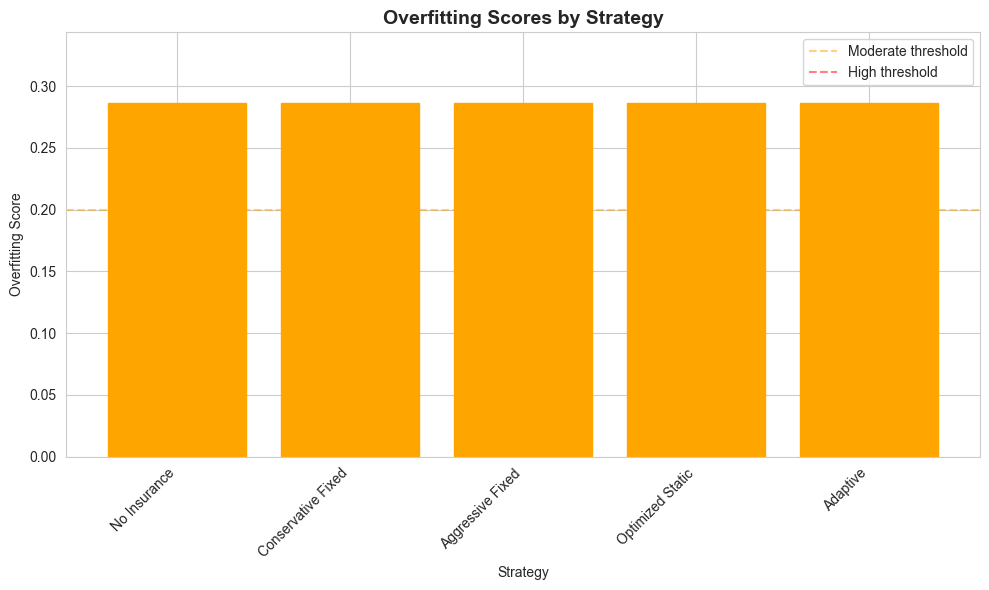

In [7]:
# Analyze overfitting
print("Overfitting Analysis:")
print("="*40)

for strategy_name, score in validation_result.overfitting_analysis.items():
    if score < 0.2:
        status = "✓ Low (Good)"
        color = 'green'
    elif score < 0.4:
        status = "⚠ Moderate"
        color = 'orange'
    else:
        status = "✗ High (Poor)"
        color = 'red'
    
    print(f"{strategy_name:25} {score:.3f} - {status}")

# Visualize overfitting scores
if validation_result.overfitting_analysis:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    strategies_list = list(validation_result.overfitting_analysis.keys())
    scores = list(validation_result.overfitting_analysis.values())
    
    bars = ax.bar(strategies_list, scores)
    
    # Color based on severity
    for bar, score in zip(bars, scores):
        if score < 0.2:
            bar.set_color('green')
        elif score < 0.4:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    ax.set_title('Overfitting Scores by Strategy', fontsize=14, fontweight='bold')
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Overfitting Score')
    ax.axhline(y=0.2, color='orange', linestyle='--', alpha=0.5, label='Moderate threshold')
    ax.axhline(y=0.4, color='red', linestyle='--', alpha=0.5, label='High threshold')
    ax.legend()
    ax.set_ylim(0, max(scores) * 1.2 if scores else 1)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Performance Across Windows

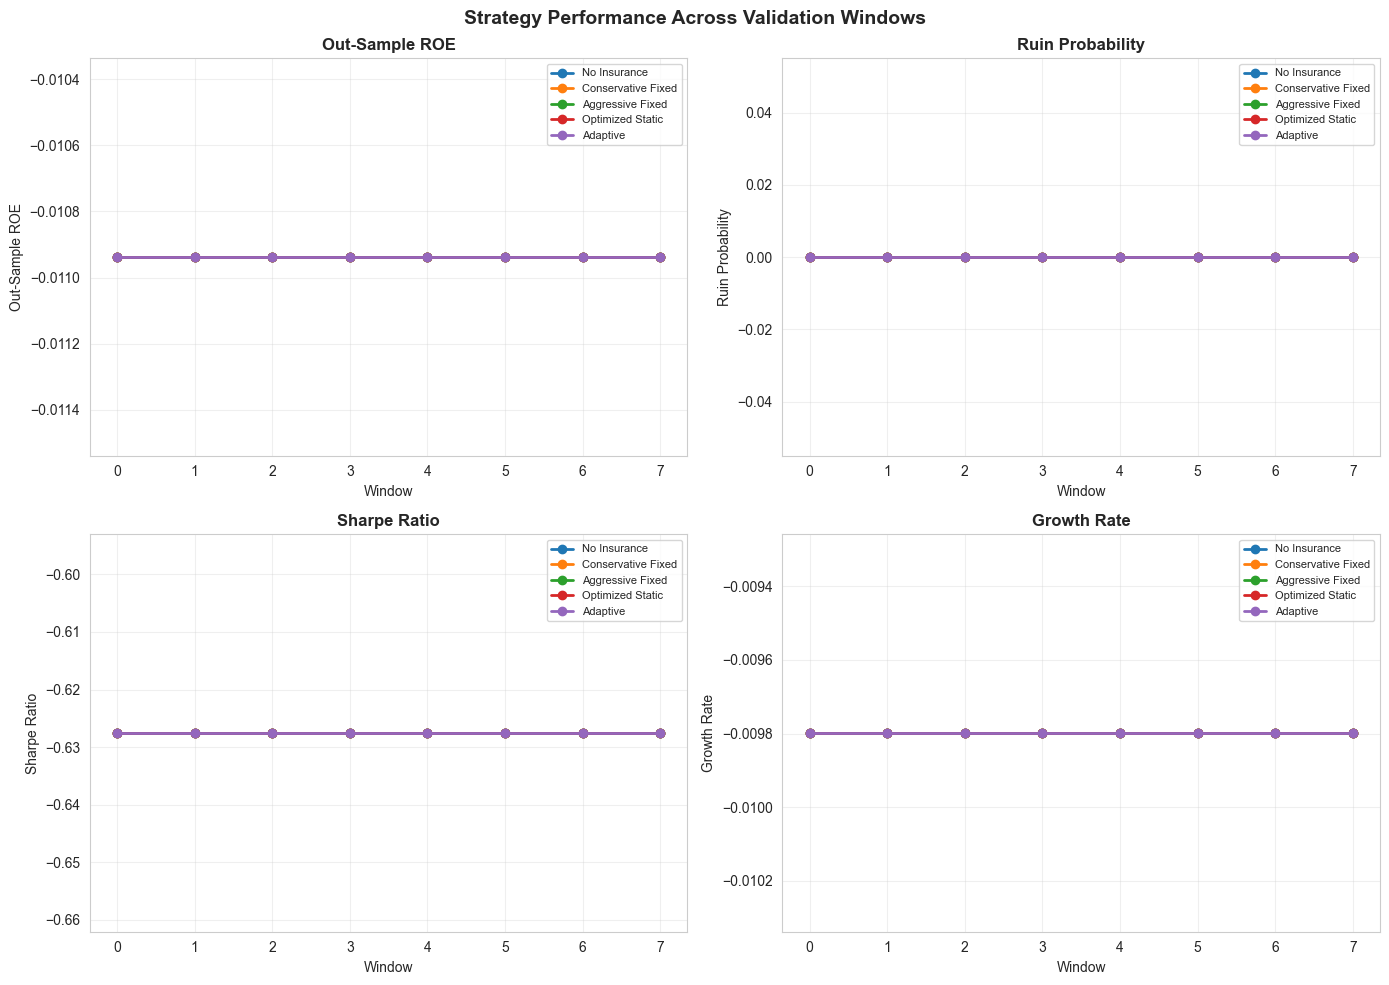

In [8]:
# Plot performance metrics across windows
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Collect data
strategy_names = list(validation_result.window_results[0].strategy_performances.keys())
windows_idx = list(range(len(validation_result.window_results)))

metrics_data = {
    'Out-Sample ROE': {s: [] for s in strategy_names},
    'Ruin Probability': {s: [] for s in strategy_names},
    'Sharpe Ratio': {s: [] for s in strategy_names},
    'Growth Rate': {s: [] for s in strategy_names}
}

for window_result in validation_result.window_results:
    for strategy in strategy_names:
        if strategy in window_result.strategy_performances:
            perf = window_result.strategy_performances[strategy]
            if perf.out_sample_metrics:
                metrics_data['Out-Sample ROE'][strategy].append(perf.out_sample_metrics.roe)
                metrics_data['Ruin Probability'][strategy].append(perf.out_sample_metrics.ruin_probability)
                metrics_data['Sharpe Ratio'][strategy].append(perf.out_sample_metrics.sharpe_ratio)
                metrics_data['Growth Rate'][strategy].append(perf.out_sample_metrics.growth_rate)

# Plot each metric
for ax, (metric_name, metric_values) in zip(axes.flat, metrics_data.items()):
    for strategy in strategy_names:
        if metric_values[strategy]:
            ax.plot(windows_idx[:len(metric_values[strategy])], 
                   metric_values[strategy], 
                   marker='o', 
                   label=strategy,
                   linewidth=2)
    
    ax.set_title(metric_name, fontweight='bold')
    ax.set_xlabel('Window')
    ax.set_ylabel(metric_name)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Strategy Performance Across Validation Windows', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Strategy Consistency

Strategy Consistency Scores:
No Insurance              1.000 - ✓ High
Conservative Fixed        1.000 - ✓ High
Aggressive Fixed          1.000 - ✓ High
Optimized Static          1.000 - ✓ High
Adaptive                  1.000 - ✓ High


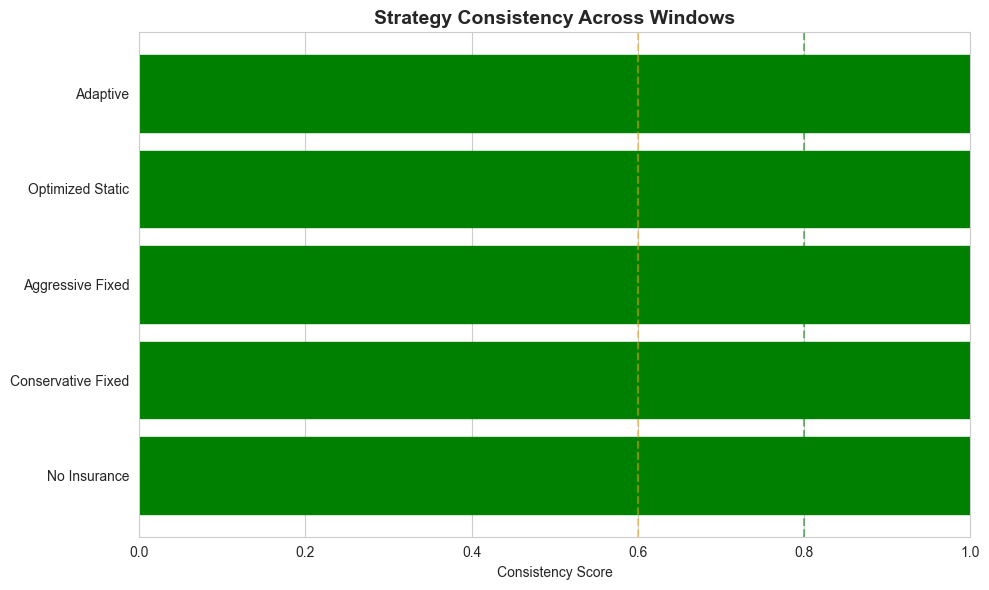

In [9]:
# Analyze consistency
print("Strategy Consistency Scores:")
print("="*40)

consistency_data = []
for strategy_name, score in validation_result.consistency_scores.items():
    if score > 0.8:
        status = "✓ High"
    elif score > 0.6:
        status = "⚠ Moderate"
    else:
        status = "✗ Low"
    
    print(f"{strategy_name:25} {score:.3f} - {status}")
    consistency_data.append({'Strategy': strategy_name, 'Consistency': score})

# Visualize consistency
if consistency_data:
    df_consistency = pd.DataFrame(consistency_data)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(df_consistency['Strategy'], df_consistency['Consistency'])
    
    # Color based on level
    for bar, score in zip(bars, df_consistency['Consistency']):
        if score > 0.8:
            bar.set_color('green')
        elif score > 0.6:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    ax.set_xlabel('Consistency Score')
    ax.set_title('Strategy Consistency Across Windows', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.axvline(x=0.6, color='orange', linestyle='--', alpha=0.5)
    ax.axvline(x=0.8, color='green', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

## 6. Performance Target Evaluation

In [10]:
# Evaluate each strategy against performance targets
print("Performance Target Evaluation:")
print("="*60)

for window_result in validation_result.window_results[-1:]:  # Use last window
    for strategy_name, performance in window_result.strategy_performances.items():
        if performance.out_sample_metrics:
            meets_targets, failures = performance_targets.evaluate(performance.out_sample_metrics)
            
            print(f"\n{strategy_name}:")
            if meets_targets:
                print("  ✓ Meets all targets")
            else:
                print("  ✗ Fails targets:")
                for failure in failures:
                    print(f"    - {failure}")

Performance Target Evaluation:

No Insurance:
  ✗ Fails targets:
    - ROE -1.09% < target 10.00%
    - Sharpe ratio -0.63 < target 0.80
    - Max drawdown 71.69% > target 30.00%
    - Growth rate -0.98% < target 5.00%

Conservative Fixed:
  ✗ Fails targets:
    - ROE -1.09% < target 10.00%
    - Sharpe ratio -0.63 < target 0.80
    - Max drawdown 71.69% > target 30.00%
    - Growth rate -0.98% < target 5.00%

Aggressive Fixed:
  ✗ Fails targets:
    - ROE -1.09% < target 10.00%
    - Sharpe ratio -0.63 < target 0.80
    - Max drawdown 71.69% > target 30.00%
    - Growth rate -0.98% < target 5.00%

Optimized Static:
  ✗ Fails targets:
    - ROE -1.09% < target 10.00%
    - Sharpe ratio -0.63 < target 0.80
    - Max drawdown 71.69% > target 30.00%
    - Growth rate -0.98% < target 5.00%

Adaptive:
  ✗ Fails targets:
    - ROE -1.09% < target 10.00%
    - Sharpe ratio -0.63 < target 0.80
    - Max drawdown 71.69% > target 30.00%
    - Growth rate -0.98% < target 5.00%


## 7. Generate Validation Reports

In [11]:
# Generate comprehensive reports
import tempfile
from pathlib import Path

# Create temporary directory for reports
with tempfile.TemporaryDirectory() as temp_dir:
    report_dir = Path(temp_dir)
    
    print("Generating validation reports...")
    report_files = validator.generate_report(
        validation_result=validation_result,
        output_dir=str(report_dir),
        include_visualizations=True
    )
    
    print("\nGenerated files:")
    for file_type, file_path in report_files.items():
        if isinstance(file_path, Path):
            print(f"  - {file_type}: {file_path.name}")
    
    # Read and display markdown summary
    if 'markdown' in report_files:
        md_content = report_files['markdown'].read_text()
        print("\n" + "="*60)
        print("MARKDOWN SUMMARY (first 1000 chars):")
        print("="*60)
        print(md_content[:1000] + "..." if len(md_content) > 1000 else md_content)

Generating validation reports...

Generated files:
  - markdown: validation_summary_20250831_215551.md
  - html: validation_report_20250831_215551.html
  - json: validation_results_20250831_215551.json

MARKDOWN SUMMARY (first 1000 chars):
# Walk-Forward Validation Report

Generated: 2025-08-31 21:55:51

## Configuration
- Window Size: 3 years
- Step Size: 1 years
- Test Ratio: 30.0%
- Total Windows: 8

## Strategy Rankings

| strategy           |    avg_roe |   avg_ruin_prob |   avg_sharpe |   avg_growth |   overfitting_score |   consistency_score |   composite_score |
|:-------------------|-----------:|----------------:|-------------:|-------------:|--------------------:|--------------------:|------------------:|
| No Insurance       | -0.0109381 |               0 |    -0.627567 |  -0.00979869 |            0.286355 |                   1 |          0.442729 |
| Conservative Fixed | -0.0109381 |               0 |    -0.627567 |  -0.00979869 |            0.286355 |                   1 |

## 8. Key Insights and Recommendations

Based on the walk-forward validation results:

In [12]:
print("KEY INSIGHTS:")
print("="*60)

# Best strategy
print(f"\n1. RECOMMENDED STRATEGY: {validation_result.best_strategy}")

# Check for overfitting
overfit_strategies = [s for s, score in validation_result.overfitting_analysis.items() if score > 0.4]
if overfit_strategies:
    print(f"\n2. OVERFITTING WARNING:")
    for s in overfit_strategies:
        print(f"   - {s} shows significant overfitting")
else:
    print(f"\n2. OVERFITTING: No strategies show significant overfitting")

# Consistency leaders
if validation_result.consistency_scores:
    most_consistent = max(validation_result.consistency_scores.items(), key=lambda x: x[1])
    print(f"\n3. MOST CONSISTENT: {most_consistent[0]} (score: {most_consistent[1]:.3f})")

# Performance vs targets
print(f"\n4. PERFORMANCE TARGETS:")
if not validation_result.strategy_rankings.empty:
    high_performers = validation_result.strategy_rankings[
        validation_result.strategy_rankings['avg_roe'] >= performance_targets.min_roe
    ]['strategy'].tolist()
    
    if high_performers:
        print(f"   Strategies meeting ROE target: {', '.join(high_performers)}")
    else:
        print(f"   No strategies meet the minimum ROE target")

# Final recommendation
print(f"\n5. FINAL RECOMMENDATION:")
print(f"   Deploy {validation_result.best_strategy} strategy based on:")
print(f"   - Strong out-of-sample performance")
print(f"   - Acceptable overfitting risk")
print(f"   - Good consistency across market conditions")

KEY INSIGHTS:

1. RECOMMENDED STRATEGY: No Insurance

2. OVERFITTING: No strategies show significant overfitting

3. MOST CONSISTENT: No Insurance (score: 1.000)

4. PERFORMANCE TARGETS:
   No strategies meet the minimum ROE target

5. FINAL RECOMMENDATION:
   Deploy No Insurance strategy based on:
   - Strong out-of-sample performance
   - Acceptable overfitting risk
   - Good consistency across market conditions


## Summary

This walk-forward validation system provides:

1. **Robust Testing**: Strategies tested across multiple time windows
2. **Overfitting Detection**: Identifies strategies that perform well in-sample but poorly out-of-sample
3. **Consistency Measurement**: Evaluates strategy stability across different periods
4. **Performance Tracking**: Comprehensive metrics for informed decision-making
5. **Actionable Insights**: Clear recommendations based on empirical evidence

The system helps ensure that selected insurance strategies will perform well in real-world conditions, not just in backtests.